# Imports

In [5]:
# Python standard library
import sys
import csv

# Scientific computing
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage

# Program specific
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/rp/')
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/')
import resistive_pulse as rp
import optical_imaging as oi
import oi_file


# Jupyter
from IPython.display import HTML

## Load data

In [6]:
date = '7-17-2017/'
particle = '293-T/'
channel = '15-30-15_6/'
file_index = '0'

base_path = '/home/prestonh/Desktop/Research/cancer_cells/data/'

oi_vid_file_path = base_path + date + particle + channel + 'oi/bin/test_camera_' + file_index
oi_events_file_path = base_path + date + particle + channel + 'oi/events/test_camera_' + file_index + '_events_filtered.json'

In [7]:
# Load video
oi_vid = oi_file.Video(oi_vid_file_path, 512, 288, 100000)

# Load events
oi_events = oi_file.open_event_file_json(oi_events_file_path)

## Load ellipses

In [8]:
ellipsess_file_path = '../data/' + date + particle + channel + 'ellipses_' + file_index

# Load ellipsess from text file
ellipsess = []
with open(ellipsess_file_path, 'r') as file_handle:
    file_reader = csv.reader(file_handle, delimiter = '\t')
    
    # Skip header
    header_length = 2
    for i in range(header_length):
        row = next(file_reader)
        
    while row:
        row = next(file_reader)
        
        
        if row[0] == 'event #':
            ellipsess.append([])

        else:            
            ellipsess[-1].append([float(ele) for ele in row])

StopIteration: 

## Load template and create stage

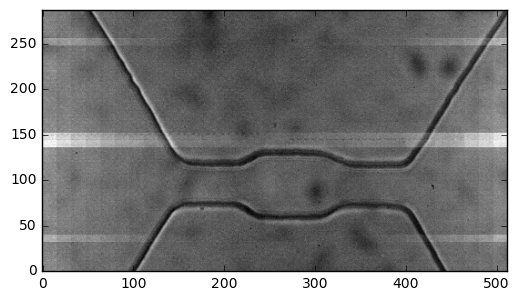

In [9]:
template_index = 0

template_frame = oi_vid.get_frame(template_index)

plt.imshow(template_frame, cmap = 'gray', origin = 'lower')
plt.show()

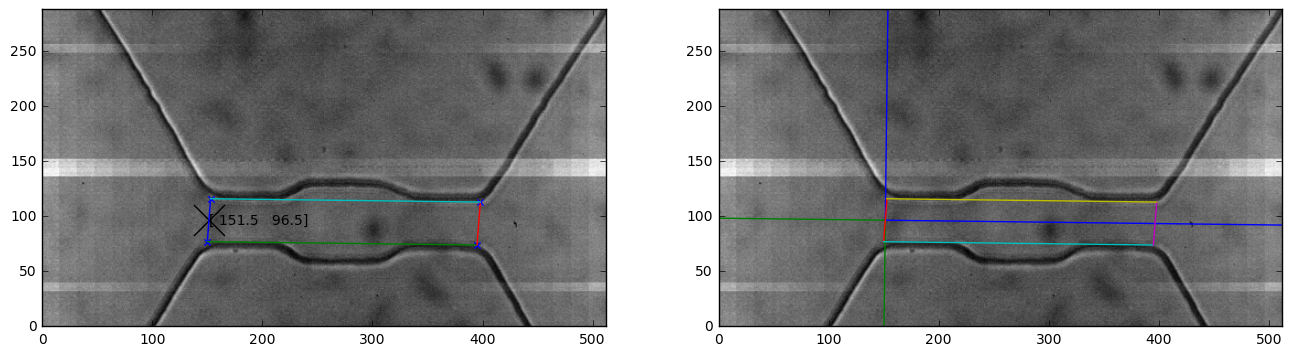

In [12]:
reload(oi)
template_index = 0
template_frame = oi_vid.get_frame(template_index)
c0 = [153,116]
c1 = [150,77]
c2 = [395,74]
c3 = [398,113]

oi_stage = oi.Stage(template_frame, c0, c1, c2, c3)
oi_stage.plot_stage()

## Calculate average velocity

In [13]:
velocities = []

for i, ellipses in enumerate(ellipsess):
    ts = []
    xs = []
    ys = []
    for ellipse in ellipses:
        detection_index = ellipse[0]
        ts.append(oi_events[i]._detections[int(detection_index)]._tf)
        xs.append(ellipse[1])
        ys.append(ellipse[2])
        
    ts = np.array(ts)
    ts = ts/100000.
    xcs, ycs = oi_stage.get_channel_coordinates(xs, ys)
    xcs = oi_stage.pixels_to_meters(xcs)
    
    ts_interp = scipy.interpolate.interp1d(xcs, ts)
    
    dx = oi_stage._length_microns*10**(-6.)
    dt = ts_interp(oi_stage._length_microns) - ts_interp(0)
    
    velocities.append(dx/dt)

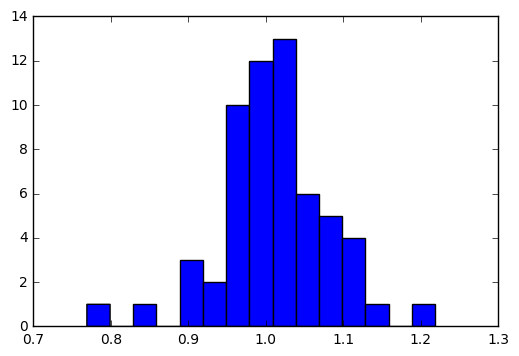

In [14]:
plt.hist(velocities, bins = 15)
plt.show()

## Save data

In [16]:
output_file_path = '../data/' + date + particle + channel + 'velocities_' + file_index
print output_file_path


with open(output_file_path, 'w') as file_handle:
    file_writer = csv.writer(file_handle, delimiter = '\t')
    
    # Write header
    file_writer.writerow([date + particle + channel + 'velocities_' + file_index])
    
    # Write data
    for i in range(len(velocities)):
        file_writer.writerow(['event #', i])
        file_writer.writerow([round(velocities[i], 5)])

../data/7-17-2017/293-T/15-30-15_6/velocities_0
